# Sawyer Jacobson
## Data Science Capstone, Final Project
## Using Machine Learning to Predict NHL Game Outcomes

### 6/2/2021

This project will use data scraped from the NHL statsapi on the overall team and player levels to predict the outcome of regular season NHL games. 
This is a binary classification problem so the appropriate algorithms will be used. I am particularly interested in obtaining the probability of 
winning for a team in the game. The target for predictions will be whether or not the home team won/will win and the associated probabilities.

In [43]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [44]:
player_stats = pd.read_csv("data/game_player_stats_full.csv")
goalie_stats = pd.read_csv("data/game_goalie_stats_full.csv")
game_results = pd.read_csv("data/game_results_full.csv")
team_stats_game = pd.read_csv("data/game_team_stats_full.csv")
officials_game = pd.read_csv("data/game_officials_full.csv")

# game_results = game_results.query("gameID <= 2019021082")
# team_stats_game = team_stats_game.query("gameID <= 2019021082")

## setting the ID columns to characters
# game results IDs
game_ID_cols = game_results.filter(like="ID").columns.to_list()
game_results[game_ID_cols] = game_results[game_ID_cols].astype(str)

# team stats IDs
ID_cols = team_stats_game.filter(like="ID").columns.to_list()
team_stats_game[ID_cols] = team_stats_game[ID_cols].astype(str)

# player stats IDs
player_ID_cols = player_stats.filter(like="ID").columns.to_list()
player_stats[player_ID_cols] = player_stats[player_ID_cols].astype(str)

# goalie stats IDs
goalie_ID_cols = goalie_stats.filter(like="ID").columns.to_list()
goalie_stats[goalie_ID_cols] = goalie_stats[goalie_ID_cols].astype(str)

# dropping periods played column. Not going to do much good right now
team_stats_game.drop(columns="periodsPlayed", inplace=True)

# converting game dateTime to a date
game_results["dateTime"] = pd.to_datetime(game_results.dateTime).dt.date

player_stats.shape
goalie_stats.shape
game_results.shape
team_stats_game.shape
officials_game.shape

(453237, 27)

(27104, 24)

(12592, 12)

(25181, 17)

(50422, 3)

# Exploratory data analysis

First we'll check to see that all the data game in in the proper format. Some of the player ice time columns will need to be fixed using the function used for the player analysis project.

Also check to see what data is missing. Since I collected the data in a specific manner, missing data should be just the absence of data and in most cases will mean 0, False, whatever is the appropriate base case for that type of variable.

Since our interest is in the game data, let's see how the games are distributed in terms of results and scoring.

In [45]:
pd.set_option("max_info_columns", player_stats.shape[1])
pd.set_option("max_columns", player_stats.shape[1])

# checking the data types of each column to see what else needs to be cleaned
player_stats.info()
goalie_stats.info()
game_results.info()
team_stats_game.info()
officials_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453237 entries, 0 to 453236
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameID                453237 non-null  object 
 1   playerID              453237 non-null  object 
 2   fullName              453237 non-null  object 
 3   position              453237 non-null  object 
 4   homeAway              453237 non-null  object 
 5   teamID                453237 non-null  object 
 6   teamName              453237 non-null  object 
 7   timeOnIce             453237 non-null  object 
 8   assists               453237 non-null  int64  
 9   goals                 453237 non-null  int64  
 10  shots                 453237 non-null  int64  
 11  hits                  453237 non-null  int64  
 12  powerPlayGoals        453237 non-null  int64  
 13  powerPlayAssists      453237 non-null  int64  
 14  penaltyMinutes        453237 non-null  int64  
 15  

Looks like everythink actually came in pretty clean! The time on ice variables need to be fixed as expected, but everything else came through nicely!

In [46]:
player_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'shots', 'hits',
       'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins',
       'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals',
       'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce',
       'powerPlayTimeOnIce', 'shortHandedTimeOnIce', 'faceOffPct'],
      dtype='object')

In [47]:
game_results.tail()

,gameID,season,dateTime,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
12587,2020020864,20202021,2021-05-18,R,23,Vancouver Canucks,20,Calgary Flames,4,2,True,Rogers Arena
12588,2020020865,20202021,2021-05-09,R,30,Minnesota Wild,24,Anaheim Ducks,4,3,True,Xcel Energy Center
12589,2020020866,20202021,2021-05-09,R,54,Vegas Golden Knights,19,St. Louis Blues,4,1,True,T-Mobile Arena
12590,2020020867,20202021,2021-05-09,R,26,Los Angeles Kings,21,Colorado Avalanche,2,3,False,STAPLES Center
12591,2020020868,20202021,2021-05-09,R,28,San Jose Sharks,53,Arizona Coyotes,4,5,False,SAP Center at San Jose


True     0.542964
False    0.457036
Name: homeTeamWin, dtype: float64

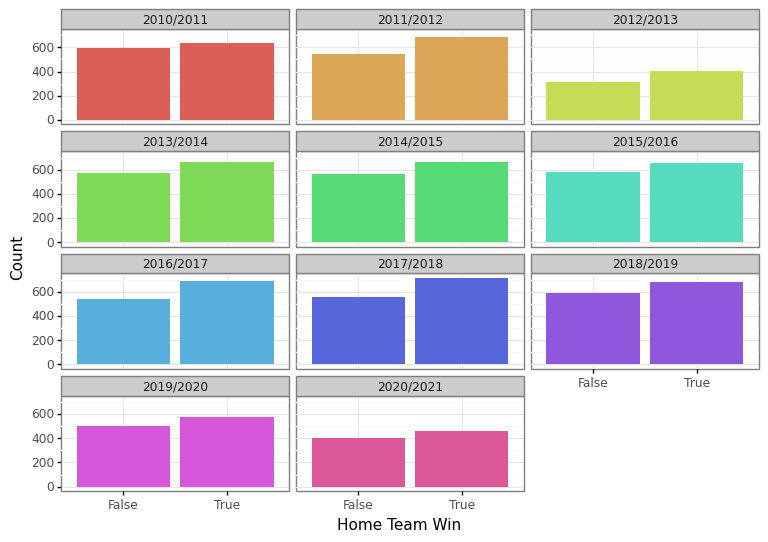

<ggplot: (352730248)>

In [48]:
# percentage of games where the home team won
game_results.homeTeamWin.value_counts()/game_results.shape[0]

def add_season(df):
    return df['gameID'].astype(str).str[0:4] + "/" + (df['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

# adding a season column
game_results["season"] = add_season(game_results)#game_results['gameID'].astype(str).str[0:4] + "/" + (game_results['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

plotnine.options.figure_size = (9, 6)

(
ggplot(game_results, aes(x = "homeTeamWin", fill = 'season')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ season", ncol = 3) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Win", y = "Count")
)

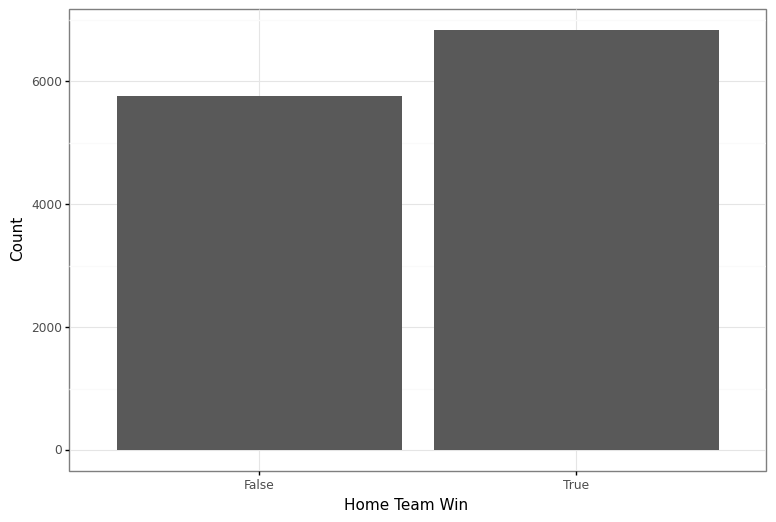

<ggplot: (352634016)>

In [49]:
(
ggplot(game_results, aes(x = "homeTeamWin")) + 
    geom_bar() + 
    theme_bw() + 
    labs(x = "Home Team Win", y = "Count")
)

In [54]:
pd.crosstab(index=game_results['season'], columns=game_results['homeTeamWin'])

game_results['homeTeamWin'].value_counts()/game_results.shape[0]

homeTeamWin,False,True
season,,
2010/2011,592,638
2011/2012,543,687
2012/2013,311,409
2013/2014,570,660
2014/2015,564,666
2015/2016,579,651
2016/2017,542,688
2017/2018,555,716
2018/2019,589,682


True     0.542964
False    0.457036
Name: homeTeamWin, dtype: float64

In almost every season from the past decade, the home team has won a slight majority of the games. The 2019/2020 season seemed to be the exception, potentially due to the season being delayed and cut short because of COVID-19.

Below, we'll create a new dataset that has a teams cumulative statistics throughout a season. These stats will be used as features in the predictive model. The difference between 2 teams cumulative stats up to the desired game in a season will be used (home team - away team) which should help determine which team is doing better in that season as well as a certain difference in performance. I intend to include other features such as whether the starter goalie has played consecutive games or not and also take into account the roster for each team. This last feature will be something of a pseudo roster strength going into the game. Theoretically this should help because the roster strength would be diminished if a star player was out hurt or something.

In [55]:
common_venues = pd.DataFrame(game_results["venue"].value_counts()).query("venue >= 50").index.to_list()

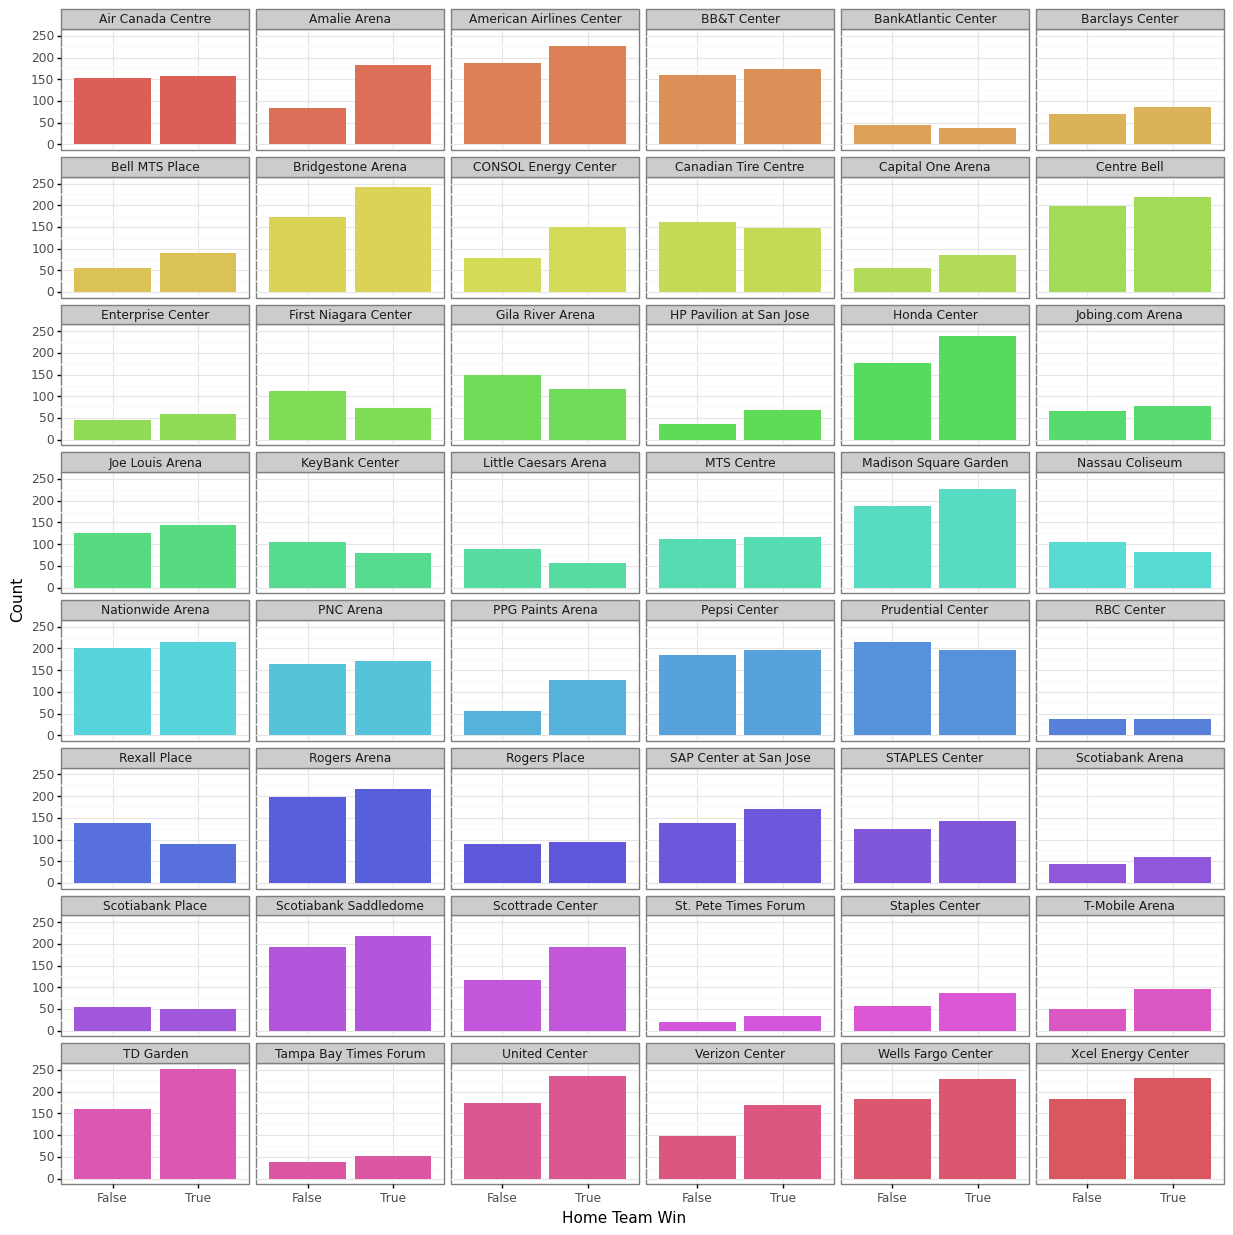

<ggplot: (381313320)>

In [56]:
plotnine.options.figure_size = (15, 15)

# number of games the home team has won at each venue thoughout the 2010-2020 season
(
ggplot(game_results[game_results['venue'].isin(common_venues)], aes(x = "homeTeamWin", fill = 'venue')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ venue", ncol = 6) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Win", y = "Count")
)

# Data Preprocessing

Here we will do the feature engineering and manipulation to get the player and team stat datasets into a form usuable for modeling. The desired modeling dataset will be the home team stats minus the away team stats. Therefore, positive numbers will signify the home team as higher stats up to that point in the season, and negative numbers will indicate that the away team has higher stats.

In [57]:
# adding win and losing streaks to the team stats
def win_lose(df):
    win_streak=0
    df["winStreak"] = 0
    lose_streak=0
    df["loseStreak"] = 0
    games_won=0
    games_lost = 0
    df["gamesWon"] = 0
    df["gamesLost"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "homeAway"] == "home" and df.loc[index, "homeTeamWin"]) or (df.loc[index, "homeAway"] == "away" and not df.loc[index, "homeTeamWin"]):
            win_streak+=1
            df.loc[index, "winStreak"] = win_streak
            lose_streak=0
            df.loc[index, "loseStreak"] = lose_streak
            games_won+=1
            df.loc[index, "gamesWon"] = games_won
            df.loc[index, "gamesLost"] = games_lost
        else:
            win_streak=0
            df.loc[index, "winStreak"] = win_streak
            lose_streak+=1
            df.loc[index, "loseStreak"] = lose_streak
            games_lost+=1
            df.loc[index, "gamesWon"] = games_won
            df.loc[index, "gamesLost"] = games_lost
    return(df)


team_stats_game['season'] = add_season(team_stats_game)
team_stats_game['gamesPlayed'] = 1
team_num_vars = team_stats_game.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_team_num_stats = team_stats_game \
    .groupby(by=['teamID', 'season'])[team_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_team_stats = pd.concat([team_stats_game.drop(columns=team_num_vars), cum_team_num_stats], axis="columns")
team_percent_cols = cum_team_stats.filter(like="Percentage").columns.to_list()
cum_team_stats[team_percent_cols] = cum_team_stats[team_percent_cols].apply(lambda x: x/cum_team_stats["gamesPlayed"])

# adding win/lose and streak columns
cum_team_stats = cum_team_stats \
    .groupby(['teamID', "season"]) \
    .apply(win_lose)


In [58]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25176,2020020866,away,True,Craig Berube,19,St. Louis Blues,2020/2021,167,456,1622,23.687500,36.0,155.0,53.346429,760,338,447,1257,56,0,3,27,29
25177,2020020867,home,False,Todd McLellan,26,Los Angeles Kings,2020/2021,142,395,1587,17.323214,32.0,169.0,50.728571,746,195,406,1065,56,0,2,21,35
25178,2020020867,away,False,Jared Bednar,21,Colorado Avalanche,2020/2021,197,499,1937,20.239286,47.0,207.0,51.691071,677,356,349,926,56,2,0,39,17
25179,2020020868,home,False,Bob Boughner,28,San Jose Sharks,2020/2021,146,514,1682,12.766071,22.0,156.0,48.337500,812,426,387,1250,56,0,2,21,35


In [59]:
pd.crosstab(index=cum_team_stats['winStreak'], columns=cum_team_stats['homeTeamWin'])

homeTeamWin,False,True
winStreak,,
0,5755,6835
1,2869,3374
2,1430,1699
3,695,850
4,355,422
5,190,222
6,107,117
7,48,68
8,20,40


Here, the same process will be used to create a cumulative player stats dataset for each season.

In [60]:
player_stats["season"] = add_season(player_stats)
player_stats["gamesPlayed"] = 1
player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]] = player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]].fillna(value=0)

# adding a point streak column for players
def point_streak(df):
    point_streak=0
    df["pointStreak"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "assists"] > 0 or df.loc[index, 'goals'] > 0):
            point_streak+=1
            df.loc[index, "pointStreak"] = point_streak
        else:
            point_streak=0
            df.loc[index, "pointStreak"] = point_streak
    return(df)

# function to clean the time on ice from minutes:seconds format to a decimal
def clean_toi(x):
    time = x.str.split(":")
    minutes = time.str.get(0)
    seconds = time.str.get(1).astype(int)*100/60
    return minutes + "." + seconds.round().astype(int).astype(str)

time_on_ice_cols = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce', 'shortHandedTimeOnIce']
# had to change the clean_toi function a few times because the list wasn't working right...
player_stats[time_on_ice_cols] = player_stats[time_on_ice_cols].apply(clean_toi).astype(float)

player_num_vars = player_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# adding player point streak column
player_stats = player_stats \
    .groupby(['playerID', 'season']) \
    .apply(point_streak)

# creating cumulative totals for the 
cum_player_num_stats = player_stats \
    .groupby(by=['playerID', 'season'])[player_num_vars] \
    .cumsum()

# creating the full cumulative team stats dataframe
cum_player_stats = pd.concat([player_stats.drop(columns=player_num_vars), cum_player_num_stats], 
                             axis="columns")

# turning time on ice stats into season averages
cum_player_stats[time_on_ice_cols] = cum_player_stats[time_on_ice_cols].apply(lambda x: x/cum_player_stats['gamesPlayed'])

# function to determine if a player is on a hot streak
def hot_players(x, thresh):
    return x >= thresh
cum_player_stats["hotPlayer"] = hot_players(cum_player_stats.pointStreak, 2).astype(int)
cum_player_stats["faceOffPct"] = cum_player_stats["faceOffWins"] / cum_player_stats['faceoffTaken']
cum_player_stats["faceOffPct"] = cum_player_stats["faceOffPct"].fillna(value=0)

In [61]:
# cum_player_stats["faceOffPct"] = cum_player_stats["faceOffWins"] / cum_player_stats['faceoffTaken']
# cum_player_stats["faceOffPct"] = cum_player_stats["faceOffPct"].fillna(value=0)
cum_player_stats


,gameID,playerID,fullName,position,homeAway,teamID,teamName,season,pointStreak,timeOnIce,assists,goals,shots,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct,gamesPlayed,hotPlayer
0,2010020001,8468778,Colton Orr,R,home,10,Toronto Maple Leafs,2010/2011,0,3.320000,0,0,0,...,0,0,0,0,0,0,1,3.320000,0.000000,0.000000,0.000000,1,0
1,2010020001,8470602,Dion Phaneuf,D,home,10,Toronto Maple Leafs,2010/2011,1,23.750000,1,0,2,...,0,0,1,0,0,3,1,15.180000,6.780000,1.780000,0.000000,1,0
2,2010020001,8465200,Tomas Kaberle,D,home,10,Toronto Maple Leafs,2010/2011,0,23.920000,0,0,2,...,0,0,0,0,0,2,0,16.270000,7.650000,0.000000,0.000000,1,0
3,2010020001,8467400,Francois Beauchemin,D,home,10,Toronto Maple Leafs,2010/2011,0,22.350000,0,0,1,...,0,1,2,0,0,3,0,15.700000,3.420000,3.230000,0.000000,1,0
4,2010020001,8474125,Carl Gunnarsson,D,home,10,Toronto Maple Leafs,2010/2011,0,17.550000,0,0,1,...,0,1,3,0,0,2,1,13.320000,1.470000,2.770000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453232,2020020868,8478047,Michael Bunting,L,away,53,Arizona Coyotes,2020/2021,0,16.752381,3,10,38,...,12,9,5,0,0,1,-1,14.839524,1.917619,0.042857,0.583333,21,0
453233,2020020868,8477392,Hudson Fasching,R,away,53,Arizona Coyotes,2020/2021,0,9.464000,0,0,7,...,0,0,1,0,0,1,-3,9.328000,0.000000,0.136000,0.000000,5,0
453234,2020020868,8480890,Jan Jenik,R,away,53,Arizona Coyotes,2020/2021,2,12.215000,0,2,3,...,23,1,0,0,0,0,3,12.215000,0.000000,0.000000,0.521739,2,1
453235,2020020868,8475171,Oliver Ekman-Larsson,D,away,53,Arizona Coyotes,2020/2021,3,21.005000,21,3,83,...,0,12,25,0,0,26,-17,16.874565,2.402826,1.754783,0.000000,46,1


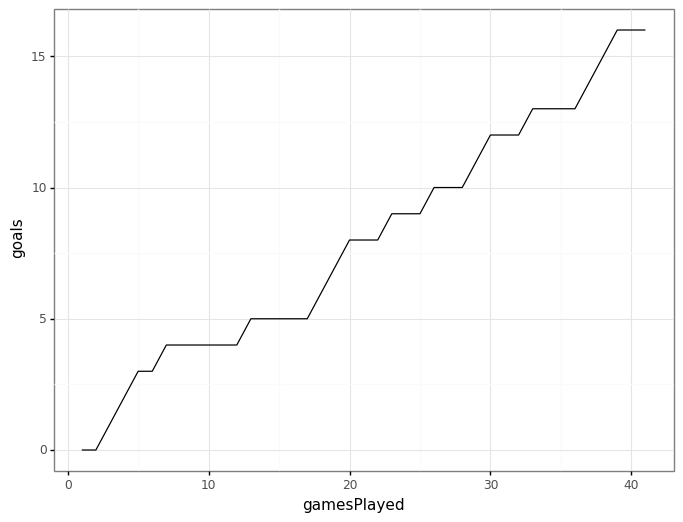

<ggplot: (381034659)>

In [62]:
plotnine.options.figure_size = (8, 6)

(
ggplot(cum_player_stats.query("fullName == 'Sidney Crosby' & season == '2019/2020'"), aes(x = "gamesPlayed", y = "goals")) + 
    geom_line() + 
    theme_bw()
)

Lastly we'll do the same cumulative stats for goalies.


In [63]:
goalie_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'pim', 'shots', 'saves',
       'powerPlaySaves', 'shortHandedSaves', 'evenSaves',
       'shortHandedShotsAgainst', 'evenShotsAgainst', 'powerPlayShotsAgainst',
       'decision', 'savePercentage', 'powerPlaySavePercentage',
       'shortHandedSavePercentage', 'evenStrengthSavePercentage'],
      dtype='object')

In [64]:
goalie_stats["season"] = add_season(goalie_stats)
goalie_stats["gamesPlayed"] = 1
goalie_num_vars = goalie_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_goalie_num_stats = goalie_stats \
    .groupby(by=['playerID', 'season'])[goalie_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_goalie_stats = pd.concat([goalie_stats.drop(columns=goalie_num_vars), cum_goalie_num_stats], axis="columns")

save_percentages = ["savePercentage", "powerPlaySavePercentage", "shortHandedSavePercentage", "evenStrengthSavePercentage"]

cum_goalie_stats[save_percentages] = cum_goalie_stats[save_percentages].fillna(value=0).apply(lambda x: x/cum_goalie_stats["gamesPlayed"])

In [65]:
cum_goalie_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,decision,season,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,savePercentage,powerPlaySavePercentage,shortHandedSavePercentage,evenStrengthSavePercentage,gamesPlayed
0,2010020001,8462044,Jean-Sebastien Giguere,G,home,10,Toronto Maple Leafs,58:49,W,2010/2011,0,0,0,28,26,3,2,21,2,23,3,92.857143,100.000000,100.000000,91.304348,1
1,2010020001,8471679,Carey Price,G,away,8,Montréal Canadiens,58:59,L,2010/2011,0,0,0,24,21,2,0,19,0,22,2,87.500000,100.000000,0.000000,86.363636,1
2,2010020002,8470594,Marc-Andre Fleury,G,home,5,Pittsburgh Penguins,58:47,L,2010/2011,0,0,0,27,24,3,1,20,2,21,4,88.888889,75.000000,50.000000,95.238095,1
3,2010020002,8475683,Sergei Bobrovsky,G,away,4,Philadelphia Flyers,60:00,W,2010/2011,0,0,0,31,29,3,1,25,1,26,4,93.548387,75.000000,100.000000,96.153846,1
4,2010020003,8473404,Niklas Backstrom,G,home,30,Minnesota Wild,58:45,L,2010/2011,0,0,0,31,27,1,1,25,1,27,3,87.096774,33.333333,100.000000,92.592593,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27099,2020020866,8478024,Ville Husso,G,away,19,St. Louis Blues,58:57,L,2020/2021,0,0,4,460,411,65,9,337,10,374,76,88.351681,76.587302,89.192179,32.352941,17
27100,2020020867,8477361,Calvin Petersen,G,home,26,Los Angeles Kings,58:03,L,2020/2021,1,0,0,1095,998,154,34,810,37,885,173,90.853910,78.937642,91.510090,0.000000,35
27101,2020020867,8477992,Jonas Johansson,G,away,21,Colorado Avalanche,59:53,W,2020/2021,0,0,0,380,341,52,4,285,4,318,58,83.860602,71.616162,83.707053,0.000000,15
27102,2020020868,8482246,Alexei Melnichuk,G,home,28,San Jose Sharks,61:24,L,2020/2021,0,0,0,81,70,7,1,62,1,72,8,90.246212,33.333333,90.150150,33.333333,3


In [66]:
def goalie_consec_games(df):
    consec_games = 0
    df["goalieConsecutiveGames"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "playerID"] == df.shift(1).loc[index, "playerID"]):
            consec_games+=1
            df.loc[index, "goalieConsecutiveGames"] = consec_games
        else:
            consec_games=0
            df.loc[index, "goalieConsecutiveGames"] = consec_games
    
    return(df)

cum_goalie_stats = cum_goalie_stats \
    .groupby(['teamID', 'season']) \
    .apply(goalie_consec_games)
# goalie_consec_games(cum_goalie_stats.query("teamID == '10' & season == '2011/2012'"))

# cum_goalie_stats.query("teamID == '10' & season == '2011/2012'").shift(1)#.iloc[0].shift(1)

In [67]:
cum_goalie_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,decision,season,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,savePercentage,powerPlaySavePercentage,shortHandedSavePercentage,evenStrengthSavePercentage,gamesPlayed,goalieConsecutiveGames
0,2010020001,8462044,Jean-Sebastien Giguere,G,home,10,Toronto Maple Leafs,58:49,W,2010/2011,0,0,0,28,26,3,2,21,2,23,3,92.857143,100.000000,100.000000,91.304348,1,0
1,2010020001,8471679,Carey Price,G,away,8,Montréal Canadiens,58:59,L,2010/2011,0,0,0,24,21,2,0,19,0,22,2,87.500000,100.000000,0.000000,86.363636,1,0
2,2010020002,8470594,Marc-Andre Fleury,G,home,5,Pittsburgh Penguins,58:47,L,2010/2011,0,0,0,27,24,3,1,20,2,21,4,88.888889,75.000000,50.000000,95.238095,1,0
3,2010020002,8475683,Sergei Bobrovsky,G,away,4,Philadelphia Flyers,60:00,W,2010/2011,0,0,0,31,29,3,1,25,1,26,4,93.548387,75.000000,100.000000,96.153846,1,0
4,2010020003,8473404,Niklas Backstrom,G,home,30,Minnesota Wild,58:45,L,2010/2011,0,0,0,31,27,1,1,25,1,27,3,87.096774,33.333333,100.000000,92.592593,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27099,2020020866,8478024,Ville Husso,G,away,19,St. Louis Blues,58:57,L,2020/2021,0,0,4,460,411,65,9,337,10,374,76,88.351681,76.587302,89.192179,32.352941,17,0
27100,2020020867,8477361,Calvin Petersen,G,home,26,Los Angeles Kings,58:03,L,2020/2021,1,0,0,1095,998,154,34,810,37,885,173,90.853910,78.937642,91.510090,0.000000,35,3
27101,2020020867,8477992,Jonas Johansson,G,away,21,Colorado Avalanche,59:53,W,2020/2021,0,0,0,380,341,52,4,285,4,318,58,83.860602,71.616162,83.707053,0.000000,15,0
27102,2020020868,8482246,Alexei Melnichuk,G,home,28,San Jose Sharks,61:24,L,2020/2021,0,0,0,81,70,7,1,62,1,72,8,90.246212,33.333333,90.150150,33.333333,3,0


In [68]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25176,2020020866,away,True,Craig Berube,19,St. Louis Blues,2020/2021,167,456,1622,23.687500,36.0,155.0,53.346429,760,338,447,1257,56,0,3,27,29
25177,2020020867,home,False,Todd McLellan,26,Los Angeles Kings,2020/2021,142,395,1587,17.323214,32.0,169.0,50.728571,746,195,406,1065,56,0,2,21,35
25178,2020020867,away,False,Jared Bednar,21,Colorado Avalanche,2020/2021,197,499,1937,20.239286,47.0,207.0,51.691071,677,356,349,926,56,2,0,39,17
25179,2020020868,home,False,Bob Boughner,28,San Jose Sharks,2020/2021,146,514,1682,12.766071,22.0,156.0,48.337500,812,426,387,1250,56,0,2,21,35


In [69]:
# counting the number of hot players each team has after each game
game_hot_players = cum_player_stats \
    .groupby(["gameID", "teamID", "season"])['hotPlayer'] \
    .sum() \
    .reset_index()

# merging these in
cum_team_stats = pd.merge(cum_team_stats, game_hot_players, on=["gameID", "teamID", "season"])

In [70]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1,0
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1,0
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25176,2020020866,away,True,Craig Berube,19,St. Louis Blues,2020/2021,167,456,1622,23.687500,36.0,155.0,53.346429,760,338,447,1257,56,0,3,27,29,0
25177,2020020867,home,False,Todd McLellan,26,Los Angeles Kings,2020/2021,142,395,1587,17.323214,32.0,169.0,50.728571,746,195,406,1065,56,0,2,21,35,3
25178,2020020867,away,False,Jared Bednar,21,Colorado Avalanche,2020/2021,197,499,1937,20.239286,47.0,207.0,51.691071,677,356,349,926,56,2,0,39,17,4
25179,2020020868,home,False,Bob Boughner,28,San Jose Sharks,2020/2021,146,514,1682,12.766071,22.0,156.0,48.337500,812,426,387,1250,56,0,2,21,35,2


In [71]:
cum_team_num_vars = cum_team_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

shifted_team_stats = cum_team_stats.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)
short_team_stats = cum_team_stats.drop(columns=cum_team_num_vars)#.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)

proper_team_stats = pd.concat([short_team_stats, shifted_team_stats], axis="columns").dropna()

# cum_team_stats.groupby(['teamID', "season"]).shift(1).dropna()

In [72]:
proper_team_stats.head()

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
14,2010020008,home,True,Paul Maurice,12,Carolina Hurricanes,2010/2011,4.0,10.0,31.0,40.0,2.0,5.0,38.8,19.0,3.0,11.0,14.0,1.0,1.0,0.0,1.0,0.0,0.0
15,2010020008,away,True,Todd Richards,30,Minnesota Wild,2010/2011,3.0,10.0,29.0,40.0,2.0,5.0,61.2,19.0,8.0,11.0,19.0,1.0,0.0,1.0,0.0,1.0,0.0
24,2010020013,home,False,Lindy Ruff,7,Buffalo Sabres,2010/2011,2.0,12.0,36.0,20.0,1.0,5.0,43.4,20.0,5.0,8.0,22.0,1.0,1.0,0.0,1.0,0.0,0.0
26,2010020014,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3.0,6.0,24.0,0.0,0.0,5.0,46.5,22.0,6.0,16.0,27.0,1.0,1.0,0.0,1.0,0.0,0.0
27,2010020014,away,True,Cory Clouston,9,Ottawa Senators,2010/2011,1.0,12.0,26.0,0.0,0.0,5.0,56.6,7.0,16.0,18.0,26.0,1.0,0.0,1.0,0.0,1.0,0.0


In [73]:
home_team = proper_team_stats.query("homeAway == 'home'").sort_values('gameID').reset_index().drop(columns="index")

In [74]:
away_team = proper_team_stats.query("homeAway == 'away'").sort_values('gameID').reset_index().drop(columns="index")

In [75]:
full_gameID_stats = pd.merge(home_team.gameID, away_team.gameID, how="inner")
full_gameID_stats['gameID'] = full_gameID_stats.gameID.astype(str)
home_team_clean = pd.merge(home_team, full_gameID_stats, how="inner", on="gameID")
away_team_clean = pd.merge(away_team, full_gameID_stats, how="inner", on="gameID")

prior_game_stats = pd.concat([full_gameID_stats, home_team_clean[cum_team_num_vars].subtract(away_team_clean[cum_team_num_vars])], axis="columns")

In [76]:
game_results.head()

,gameID,season,dateTime,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
0,2010020001,2010/2011,2010-10-07,R,10,Toronto Maple Leafs,8,Montréal Canadiens,3,2,True,Air Canada Centre
1,2010020002,2010/2011,2010-10-07,R,5,Pittsburgh Penguins,4,Philadelphia Flyers,2,3,False,CONSOL Energy Center
2,2010020003,2010/2011,2010-10-07,R,30,Minnesota Wild,12,Carolina Hurricanes,3,4,False,Hartwall Areena
3,2010020004,2010/2011,2010-10-08,R,21,Colorado Avalanche,16,Chicago Blackhawks,4,3,True,Pepsi Center
4,2010020005,2010/2011,2010-10-08,R,22,Edmonton Oilers,20,Calgary Flames,4,0,True,Rexall Place


In [77]:
prediction_df = pd.merge(game_results.filter(items=['gameID', 'season', "homeTeamWin", "venue"]), prior_game_stats, how = "inner", on="gameID")


In [78]:
prediction_df['homeTeamWin'] = prediction_df.homeTeamWin.astype(int)

In [79]:
prediction_df

,gameID,season,homeTeamWin,venue,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
0,2010020008,2010/2011,1,Hartwall Areena,1.0,0.0,2.0,0.000000,0.0,0.0,-22.400000,0.0,-5.0,0.0,-5.0,0.0,1.0,-1.0,1.0,-1.0,0.0
1,2010020014,2010/2011,1,Air Canada Centre,2.0,-6.0,-2.0,0.000000,0.0,0.0,-10.100000,15.0,-10.0,-2.0,1.0,0.0,1.0,-1.0,1.0,-1.0,0.0
2,2010020016,2010/2011,0,CONSOL Energy Center,0.0,0.0,3.0,20.000000,1.0,2.0,7.200000,-7.0,2.0,4.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010020017,2010/2011,1,Verizon Center,-1.0,4.0,1.0,-100.000000,-1.0,2.0,7.900000,4.0,11.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010020021,2010/2011,0,United Center,-1.0,-20.0,-5.0,28.600000,2.0,1.0,-18.100000,2.0,6.0,-5.0,-2.0,0.0,-1.0,1.0,-1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12391,2020020864,2020/2021,1,Rogers Arena,-9.0,102.0,-44.0,-0.503636,-5.0,-20.0,2.587273,126.0,-21.0,-157.0,-102.0,0.0,-1.0,6.0,-4.0,4.0,1.0
12392,2020020865,2020/2021,1,Xcel Energy Center,55.0,4.0,82.0,7.147273,17.0,39.0,-4.500000,82.0,12.0,-89.0,-322.0,0.0,1.0,-1.0,17.0,-17.0,1.0
12393,2020020866,2020/2021,1,T-Mobile Arena,20.0,-46.0,199.0,-8.072727,-6.0,18.0,-3.605455,84.0,63.0,-105.0,-22.0,0.0,2.0,-2.0,12.0,-12.0,4.0
12394,2020020867,2020/2021,0,STAPLES Center,-54.0,-106.0,-338.0,-2.363636,-14.0,-37.0,-1.263636,70.0,-157.0,59.0,146.0,0.0,-1.0,1.0,-17.0,17.0,0.0


In [80]:
prediction_df.homeTeamWin.value_counts()

1    6735
0    5661
Name: homeTeamWin, dtype: int64

# Predictions

This method will train on the data from 2010-2019 seasons and test on the 2019/2020 season. Very much just a test to see where we're at and get a baseline from a very basic, untuned Logistic Regression model.

In [81]:
X_train, X_test = prediction_df.query('season != "2020/2021"').drop(columns=["gameID", "season", "homeTeamWin", "venue"]), \
                  prediction_df.query('season == "2020/2021"').drop(columns=["gameID", "season", "homeTeamWin", "venue"])

y_train, y_test = prediction_df.query('season != "2020/2021"')['homeTeamWin'], \
                  prediction_df.query('season == "2020/2021"')['homeTeamWin']

X_train.shape
y_train.shape
X_test.shape
y_test.shape

(11544, 17)

(11544,)

(852, 17)

(852,)

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression(max_iter=1e4)

log_reg.fit(X_train, y_train)

train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

pd.crosstab(y_train, train_preds)
pd.crosstab(y_test, test_preds)

accuracy_score(y_train, train_preds)
accuracy_score(y_test, test_preds)

y_test.value_counts()/len(y_test)

print(classification_report(y_test, test_preds))

LogisticRegression(max_iter=10000.0)

col_0,0,1
homeTeamWin,,
0,1481,3783
1,1159,5121


col_0,0,1
homeTeamWin,,
0,125,272
1,91,364


0.5718988218988219

0.573943661971831

1    0.534038
0    0.465962
Name: homeTeamWin, dtype: float64

              precision    recall  f1-score   support

           0       0.58      0.31      0.41       397
           1       0.57      0.80      0.67       455

    accuracy                           0.57       852
   macro avg       0.58      0.56      0.54       852
weighted avg       0.58      0.57      0.55       852



In [83]:
for var, coef in zip(X_train.columns.values, log_reg.coef_[0]):
    print(var, ": ", coef, sep='')

goals: 0.0008018858731030519
pim: 0.0003828127381245629
shots: 0.0007219465796571668
powerPlayPercentage: 0.0033448321844287907
powerPlayGoals: 0.004366715749586162
powerPlayOpportunities: -0.0013687856282577878
faceOffWinPercentage: 0.00967824644657416
blocked: -0.0004632472751388059
takeaways: -6.543218537522838e-05
giveaways: -2.502395562484786e-05
hits: 7.4284374368296795e-06
gamesPlayed: -0.030724780763033553
winStreak: 0.008656181648013218
loseStreak: 0.0056300440371077004
gamesWon: 0.0005124341995732942
gamesLost: -0.03123721496260375
hotPlayer: -0.0114768230101729


So right above here can be considered a base model, training on the 2010-2019 season data and testing on the 2019/2020 games. Not great accuracy, but that is to be expected. Theoretically it should be fine to make normal train/test sets since we want the model to learn how to predict all games. In a real scenario, we would train and validate on all data up to a season, but we can also experiment this way as well. This will give a few different approaches to modeling game data.

Other models will be included in the final training/predicting as well. This will setup a couple different approaches. Could also train/validate a model on all data before a certain season and then test predictions on the next season. An example would be what was already done, but continue to do for all other seasons in the span we collected data for. Theoretically, more data being available for training should help in prediction accuracies as we get closer to current seasons, but given the nature of hockey games, there might not be any benefit which would also be interesting as well. There is the theoretical limit of game results being able to be predicted only ~62% of the time. I'm hopeful to at least get close to this number using many different models and a model ensemble. If accuracies don't change, then better features might be needed which will have to happen later. 

I should also use models that can output probabilities as well since that would be the interesting thing to see in an app: what's the probability team X will beat team Y in this game given the current status of the season. Accuracy will be used as the metric because it will only really matter if the prediction is wrong. False positives or negatives carry equal weight in that we "lost the bet" in a sports gambling situation.

The aspect of "puck luck" has to be kept in mind because of how much affect a single lucky play can have on the outcome of a game. Predicting on a high level like this won't capture that obviously, and I believe that low level prediction model that predicts during games would benefit from a reinforcement learning approach. 

Could play around with a random multiplier to win probabilites and use that in a simulation style as well.

# Modeling strategies

## Strategy 1 (OBSOLETE NOW)

- Split the data into the 2010-2019 seasons as training data
- GridSearchCV the models using this as training data and the 2019/2020 season as test data
- Determine the accuracies for those models
    - Include a voting classifier for an ensemble model just because
- Visualize results

This is similar to what was done above, but with more than just a basic algorithm and hyperparameter tuning.
Similar to how a model would be fit in prepping for a new season, using a ton of data.

## Strategy 2

- Randomly split the data into train and test sets, 80/10 split maybe 
- GridSearchCV the models using this as training data and the 2019/2020 season as test data
- Determine the accuracies for those models
    - Include a voting classifier for an ensemble model just because
- Visualize results

## Strategy 3

- In this part, I will iteratively go over the seasons, starting with 2012/2013 as the first prediction year
- Training/optimizing on all years prior to that and then testing on that years data. 
    - This will give a sense of how accuracy would have been reported over time as well as showing what kind of effect more training data has on this difficult prediction problem. 
- The goal at the end will be to plot the accuracies from these years and see if there is any interesting trends to glean from it.


Valid approach because future game results aren't really dependent on past results. This gives a slightly
different training approach that may or may not be more effective.

In [84]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Data splitting, strategy 1

## This is included in Strategy 3 below and thus will be commented out

In [ ]:
# data split for the 2010-2019 season for training and 2019/2020 season for testing
# X_train, X_test = prediction_df.query('season != "2019/2020"').drop(columns=["gameID", "season", "homeTeamWin", "venue"]), \
#                   prediction_df.query('season == "2019/2020"').drop(columns=["gameID", "season", "homeTeamWin", "venue"])

# y_train, y_test = prediction_df.query('season != "2019/2020"')['homeTeamWin'], \
#                   prediction_df.query('season == "2019/2020"')['homeTeamWin']

# X_train.shape
# y_train.shape
# X_test.shape
# y_test.shape

# Model building and evaluation

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC, LinearSVC

# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import accuracy_score

# # numeric columns to scale
# num_scale_vars = X_train.select_dtypes(include = ['float64', 'int64']).columns

# # columns for one-hot-encoding
# one_hot_columns = ["venue"]

# # transformer to scale numeric columns using standard scaler
# transform = ColumnTransformer(
#     [
#         # ('onehot', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
#         ('numeric', StandardScaler(), num_scale_vars)
#     ]
# )


# def best_model(X_train, y_train, X_test, y_test, clfs, transform, params):
#     # initializing some variables to store models and predictions in
#     best_mods, train_preds, test_preds = [], [], []
#     # transforming the train and test datasets
#     transformer = transform
#     X_train_transformed = transformer.fit_transform(X_train)
#     X_test_transformed = transformer.transform(X_test)
#     # looping through the models
#     for (name, clf), parms in zip(clfs.items(), params):
#         # using GridSearchCV to find the optimal parameters for the data
#         grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = 5, verbose=True, scoring='accuracy')
#         # grid = RandomizedSearchCV(estimator = clf, param_distributions = parms, n_jobs = -1, cv = 5, verbose=True, n_iter=20, random_state=42)
#         grid.fit(X_train_transformed, y_train)
#         best_mod = grid.best_estimator_
#         # creating predictions
#         train_pred = best_mod.predict(X_train_transformed)
#         test_pred = best_mod.predict(X_test_transformed)
#         # calculating and printing accuracies
#         train_acc = accuracy_score(y_train, train_pred)
#         test_acc = accuracy_score(y_test, test_pred)
#         print(name + " Training Accuracy:", train_acc, sep='')
#         print(name + " Test Accuracy:", test_acc, "\n", sep='')
#         # storing predictions and best CV models
#         train_preds.append(train_pred)
#         test_preds.append(test_pred)
#         best_mods.append(best_mod)
#     # return predictions, models, and transformed data
#     return(best_mods, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed)

# # list of models we want to fit
# mods = {
#     "Logistic_Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1, solver='saga'),
#     "SVM": SVC(kernel="rbf", probability=True, gamma="scale", C=1, random_state=42, max_iter=1e5),
#     "Linear_SVM": LinearSVC(penalty="l2", C = 1, random_state=42, max_iter=1e5, ),
#     "Random_Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
#     "GBM": GradientBoostingClassifier(random_state=42, n_estimators=30, max_features="sqrt", learning_rate=.1, loss='deviance'),
#     "KNN": KNeighborsClassifier(metric='manhattan', n_jobs=-1)
# }

# params = [
#     {
#         'penalty': ['l1', 'l2', 'elasticnet'],
#         "C": [0.5, 1.0]        
#     },
#     {
#         "kernel": ['poly', 'rbf', 'sigmoid'],
#         "gamma": ['scale', 'auto'],
#         "C": np.linspace(.1, 5, num=10)
#     },
#     {
#         "penalty": ['l1', 'l2'],
#         "C": np.linspace(.1, 5, num=10)
#     },
#     {
#         "max_depth": [i for i in range(9, 22, 4)],
#         "max_features": ['auto', 'sqrt'],
#         "n_estimators": [i for i in range(10, 101, 10)],
#         'bootstrap': [True, False]
#     },
#     {
#         "max_depth": [i for i in range(9, 22, 4)],
#         "max_features": ['auto', 'sqrt'],
#         "n_estimators": [i for i in range(10, 51, 5)],
#         'loss': ['deviance', 'exponential']
#     },
#     {
#         "n_neighbors": [i for i in range(5, 31, 5)],
#         'weights': ['uniform', 'distance'],
#         'metric': ['minkowski', 'manhattan']
#     }
# ]

# import time
# start = time.time()

# best_models, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed = best_model(
#     X_train, y_train, X_test, y_test, mods, transform, params
# )

# end = time.time()
# print("Model fitting took:", end - start, "seconds")

In [ ]:
# fitting the voting classifier as the ensemble model
# from sklearn.ensemble import VotingClassifier
# voting = VotingClassifier([
#     ('logistic', best_models[0]),
#     ("svm", best_models[1]),
#     ('linear_svm', best_models[2]),
#     ('rf', best_models[3]),
#     ('gbm', best_models[4]),
#     ("knn", best_models[5])
# ], voting='hard', n_jobs=-1, )

# voting.fit(X_train_transformed, y_train)
# voting.score(X_train_transformed, y_train)
# voting_test_preds = voting.predict(X_test_transformed)
# accuracy_score(y_test, voting_test_preds)
# best_models.append(voting)

In [ ]:
# best_models

# Data Splitting, Strategy 2

In [85]:
from sklearn.model_selection import train_test_split

# split the data into training and test randomly
X_train, X_test, y_train, y_test = train_test_split(prediction_df.drop(columns=["gameID", "season", "homeTeamWin", "venue"]), 
                                                    prediction_df['homeTeamWin'], test_size=.2, random_state=42)


X_train.shape
y_train.shape
X_test.shape
y_test.shape

(9916, 17)

(9916,)

(2480, 17)

(2480,)

In [86]:
# numeric columns to scale
num_scale_vars = X_train.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ["venue"]

# transformer to scale numeric columns using standard scaler
transform = ColumnTransformer(
    [
        #('onehot', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)


def best_model(X_train, y_train, X_test, y_test, clfs, transform, params, voting='hard'):
    # initializing some variables to store models and predictions in
    best_mods, train_preds, test_preds = [], [], []
    # transforming the train and test datasets
    transformer = transform
    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    # looping through the models
    for (name, clf), parms in zip(clfs.items(), params):
        # using GridSearchCV to find the optimal parameters for the data
        grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = 5, verbose=True, scoring='accuracy')
        # grid = RandomizedSearchCV(estimator = clf, param_distributions = parms, n_jobs = -1, cv = 5, verbose=True, n_iter=20, random_state=42)
        grid.fit(X_train_transformed, y_train)
        best_mod = grid.best_estimator_
        # creating predictions
        train_pred = best_mod.predict(X_train_transformed)
        test_pred = best_mod.predict(X_test_transformed)
        # calculating and printing accuracies
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        print(name + " Training Accuracy:", train_acc, sep='')
        print(name + " Test Accuracy:", test_acc, "\n", sep='')
        # storing predictions and best CV models
        train_preds.append(train_pred)
        test_preds.append(test_pred)
        best_mods.append(best_mod)
    # fitting the hard voting classifier as the ensemble model
    voting_hard = VotingClassifier([
            (name, mod) for name, mod in zip(clfs.keys(), best_mods) #if (hasattr(mod, "predict_proba") and voting == "soft") or voting == 'hard'
        ], voting="hard", n_jobs=-1)
    
    voting_hard.fit(X_train_transformed, y_train)
    train_pred = voting_hard.predict(X_train_transformed)
    test_pred = voting_hard.predict(X_test_transformed)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    print("VotingClassifier_Hard Training Accuracy:", train_acc, sep='')
    print("VotingClassifier_Hard Test Accuracy:", test_acc, "\n", sep='')
    train_preds.append(train_pred)
    test_preds.append(test_pred)
    best_mods.append(voting_hard)
    # fitting the soft voting classifier as the ensemble model
    voting_soft = VotingClassifier([
            (name, mod) for name, mod in zip(clfs.keys(), best_mods) if hasattr(mod, "predict_proba") 
        ], voting="soft", n_jobs=-1)
    voting_soft.fit(X_train_transformed, y_train)
    train_pred = voting_soft.predict(X_train_transformed)
    test_pred = voting_soft.predict(X_test_transformed)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    print("VotingClassifier_Soft Training Accuracy:", train_acc, sep='')
    print("VotingClassifier_Soft Test Accuracy:", test_acc, "\n", sep='')
    train_preds.append(train_pred)
    test_preds.append(test_pred)
    best_mods.append(voting_soft)
    
    out = {
        "best_models": best_mods,
        "train_preds": train_preds,
        "test_preds": test_preds,
        "X_train_transformed": X_train_transformed,
        "X_test_transformed": X_test_transformed,
        "transformer": transformer
    }
    # return predictions, models, and transformed data
    return(out)

# list of models we want to fit
mods = {
    "Logistic_Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1, solver='saga'),
    "SVM": SVC(kernel="rbf", probability=True, gamma="scale", C=1, random_state=42, max_iter=1e5),
    "Linear_SVM": LinearSVC(penalty="l2", C = 1, random_state=42, max_iter=1e5, ),
    "Random_Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GBM": GradientBoostingClassifier(random_state=42, n_estimators=30, max_features="sqrt", learning_rate=.1, loss='deviance'),
    "KNN": KNeighborsClassifier(metric='manhattan', n_jobs=-1)
}

params = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        "C": [0.5, 1.0]        
    },
    {
        "kernel": ['poly', 'rbf', 'sigmoid'],
        "gamma": ['scale', 'auto'],
        "C": np.linspace(.1, 5, num=5)
    },
    {
        "penalty": ['l1', 'l2'],
        "C": np.linspace(.1, 5, num=10)
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 101, 10)],
        'bootstrap': [True, False]
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'loss': ['deviance', 'exponential']
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    }
]

import time
start = time.time()

strat_2_mods = best_model(
    X_train, y_train, X_test, y_test, mods, transform, params
)

end = time.time()
print("Model fitting took:", end - start, "seconds")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56494569 0.56555088        nan 0.56524821 0.56565174        nan]


Logistic_Regression Training Accuracy:0.5709963695038321
Logistic_Regression Test Accuracy:0.5790322580645161

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM Training Accuracy:0.5717022993142397
SVM Test Accuracy:0.5721774193548387

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.56565154        nan 0.56565154        nan 0.56565154
        nan 0.56565154        nan 0.56565154        nan 0.56565154
        nan 0.56565154        nan 0.56565154        nan 0.56565154
        nan 0.56565154]


Linear_SVM Training Accuracy:0.5710972166196047
Linear_SVM Test Accuracy:0.5794354838709678

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Accuracy:0.7305365066559096
Random_Forest Test Accuracy:0.5637096774193548

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Accuracy:0.7521177894312223
GBM Test Accuracy:0.552016129032258

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Accuracy:1.0
KNN Test Accuracy:0.5512096774193549

KNN Training Accuracy:0.695542557482856
KNN Test Accuracy:0.5754032258064516

Model fitting took: 1050.2045538425446 seconds


In [90]:
strat_2_mods["best_models"]

[LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42, solver='saga'),
 SVC(C=0.1, max_iter=100000.0, probability=True, random_state=42),
 LinearSVC(C=0.1, max_iter=100000.0, random_state=42),
 RandomForestClassifier(max_depth=9, n_estimators=30, n_jobs=-1, random_state=42),
 GradientBoostingClassifier(loss='exponential', max_depth=9, max_features='sqrt',
                            n_estimators=10, random_state=42),
 KNeighborsClassifier(n_jobs=-1, n_neighbors=30, weights='distance'),
 VotingClassifier(estimators=[('Logistic_Regression',
                               LogisticRegression(max_iter=10000, n_jobs=-1,
                                                  random_state=42,
                                                  solver='saga')),
                              ('SVM',
                               SVC(C=0.1, max_iter=100000.0, probability=True,
                                   random_state=42)),
                              ('Linear_SVM',
                   

In [91]:
# # fitting the voting classifier as the ensemble model
# from sklearn.ensemble import VotingClassifier
# voting = VotingClassifier([
#     ('logistic', best_models[0]),
#     ('rf', best_models[1]),
#     ('gbm', best_models[2]),
#     ("knn", best_models[3])
# ])

# voting.fit(X_train_transformed, y_train)
# voting.score(X_train_transformed, y_train)
# voting_test_preds = voting.predict(X_test_transformed)
# accuracy_score(y_test, voting_test_preds)
# best_models.append(voting)

# Data Splitting Strategy 3

In this part, I will iteratively go over the seasons, starting with 2012/2013, and training/optimizing on all years prior to that and then testing on that years data. This will give a sense of how accuracy would have been reported over time as well as showing what kind of effect more training data has on this difficult prediction problem. The goal at the end will be to plot the accuracies from these years and see if there is any interesting trends to glean from it.

# Technically Strategy 1 is incuded in this way so I will comment that section out

In [117]:
from sklearn.ensemble import VotingClassifier
import time
from sklearn.metrics import accuracy_score

# updated function to output the voting classifier as well
def best_model(X_train, y_train, X_test, y_test, models, transformer, params, scoring_function, ensemble_model=None, cv_scoring_metric="accuracy", folds=5):
    # initializing some variables to store models and predictions in
    best_mods, train_preds, test_preds, train_accs, test_accs, fit_times = [], [], [], [], [], []
    # transforming the train and test datasets
    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    # looping through the models
    for (name, clf), parms in zip(models.items(), params):
        start = time.time()
        # using GridSearchCV to find the optimal parameters for the data
        grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = folds, verbose=True, scoring=cv_scoring_metric)
        # grid = RandomizedSearchCV(estimator = clf, param_distributions = parms, n_jobs = -1, cv = 5, verbose=True, n_iter=20, random_state=42)
        grid.fit(X_train_transformed, y_train)
        end = time.time()
        fit_times.append(end-start)
        best_mod = grid.best_estimator_
        # creating predictions
        train_pred = best_mod.predict(X_train_transformed)
        test_pred = best_mod.predict(X_test_transformed)
        # calculating and printing fitting metric
        train_acc = scoring_function(y_train, train_pred)
        test_acc = scoring_function(y_test, test_pred)
        print(f"%s Training Metric: %s, Test Metric: %s\n" % (name, train_acc, test_acc), sep='')
        # storing predictions and best CV models
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_preds.append(train_pred)
        test_preds.append(test_pred)
        best_mods.append(best_mod)
    if ensemble_model is not None:
        if ensemble_model.__name__ == "VotingRegressor":
            # fitting the soft voting classifier as the ensemble model but not including those way overfit, i.e. accuracy=1
            voting = ensemble_model([
                    (name, mod) for name, mod, acc in zip(models.keys(), best_mods, train_accs)
                ], n_jobs=-1)
            # hard voting
            start = time.time()
            voting.fit(X_train_transformed, y_train)
            end = time.time()
            fit_times.append(end-start)
            train_pred = voting.predict(X_train_transformed)
            test_pred = voting.predict(X_test_transformed)
            train_acc = scoring_function(y_train, train_pred)
            test_acc = scoring_function(y_test, test_pred)
            print(f"%s Training Metric: %s, Test Metric: %s\n" % (ensemble_model.__name__, train_acc, test_acc), "\n", sep='')
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_preds.append(train_pred)
            test_preds.append(test_pred)
            best_mods.append(voting_hard)
        elif ensemble_model.__name__ == "VotingClassifier":
            # fitting the hard voting classifier as the ensemble model
            voting_hard = ensemble_model([
                    (name, mod) for name, mod in zip(models.keys(), best_mods) #if (hasattr(mod, "predict_proba") and voting == "soft") or voting == 'hard'
                ], voting="hard", n_jobs=-1)
            # fitting the soft voting classifier as the ensemble model but not including those way overfit, i.e. accuracy=1
            voting_soft = ensemble_model([
                    (name, mod) for name, mod, acc in zip(models.keys(), best_mods, train_accs) if hasattr(mod, "predict_proba") and acc < 1
                ], voting="soft", n_jobs=-1)
            # hard voting
            start = time.time()
            voting_hard.fit(X_train_transformed, y_train)
            end = time.time()
            fit_times.append(end-start)
            train_pred = voting_hard.predict(X_train_transformed)
            test_pred = voting_hard.predict(X_test_transformed)
            train_acc = scoring_function(y_train, train_pred)
            test_acc = scoring_function(y_test, test_pred)
            print(f"VotingClassifier_Hard Training Metric: %s, Test Metric: %s\n" % (train_acc, test_acc), "\n", sep='')
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_preds.append(train_pred)
            test_preds.append(test_pred)
            best_mods.append(voting_hard)
            # soft voting
            start = time.time()
            voting_soft.fit(X_train_transformed, y_train)
            end = time.time()
            fit_times.append(end-start)
            train_pred = voting_soft.predict(X_train_transformed)
            test_pred = voting_soft.predict(X_test_transformed)
            train_acc = scoring_function(y_train, train_pred)
            test_acc = scoring_function(y_test, test_pred)
            print(f"VotingClassifier_Soft Training Metric: %s, Test Metric: %s\n" % (train_acc, test_acc), "\n", sep='')
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_preds.append(train_pred)
            test_preds.append(test_pred)
            best_mods.append(voting_soft)
    # storing all of the models/predictions/metrics/data in a dictionary
    out = {
        "best_models": best_mods,
        "train_accuracy": train_accs,
        "test_accuracy": test_accs,
        "fit_times": fit_times, 
        "train_preds": train_preds,
        "test_preds": test_preds,
        "X_train_transformed": X_train_transformed,
        "X_test_transformed": X_test_transformed,
        "transformer": transformer
    }
    # return predictions, models, and transformed data
    return(out)


def fit_optimize_season_model(data, year, models, transformer, params):
    season = str(year)+'/'+str(year+1)
    print(f"Fitting models for the %s season\n" % season)
    # data split specified season
    X_train, X_test = data[data.season.str[0:4].astype(int) < year].drop(columns=["gameID", "season", "homeTeamWin", "venue"]), \
                      data[data.season.str[0:4].astype(int) == year].drop(columns=["gameID", "season", "homeTeamWin", "venue"])
    
    y_train, y_test = data[data.season.str[0:4].astype(int) < year]['homeTeamWin'], \
                      data[data.season.str[0:4].astype(int) == year]['homeTeamWin']
    

    start = time.time()
    
    fit_mods = best_model(
        X_train = X_train, 
        y_train = y_train, 
        X_test = X_test, 
        y_test = y_test, 
        models = models, 
        transformer = transformer, 
        params = params,
        scoring_function = accuracy_score,
        cv_scoring_metric = "accuracy",
        ensemble_model = VotingClassifier,
        folds = 5
    )
    
    end = time.time()
    print("Model fitting for the ", season, " season took: ", end - start, " seconds\n", sep='')
    # adding a few more things to differentiate each season because of the different data
    fit_mods['y_train'] = y_train
    fit_mods['y_test'] = y_test
    fit_mods['season'] = [str(year)+'/'+str(year+1) for i in fit_mods["best_models"]]
    # return the dictionary of data/models
    return(fit_mods)

# numeric columns to scale
num_scale_vars = X_train.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ["venue"]

# transformer to scale numeric columns using standard scaler
transformer = ColumnTransformer(
    [
        # ('onehot', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)


# list of models we want to fit
mods = {
    "Logistic_Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1, solver='saga'),
    "SVM": SVC(kernel="rbf", probability=True, gamma="scale", C=1, random_state=42, max_iter=1e5),
    "Linear_SVM": LinearSVC(penalty="l2", C=1, random_state=42, max_iter=1e5),
    "Random_Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GBM": GradientBoostingClassifier(random_state=42, n_estimators=30, max_features="sqrt", learning_rate=.1, loss='deviance'),
    "KNN": KNeighborsClassifier(metric='manhattan', n_jobs=-1)
}

params = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        "C": [0.5, 1.0]        
    },
    {
        "kernel": ['poly', 'rbf', 'sigmoid'],
        "gamma": ['scale', 'auto'],
        "C": np.linspace(.1, 5, num=5)
    },
    {
        "penalty": ['l1', 'l2'],
        "C": np.linspace(.1, 5, num=10)
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 101, 10)],
        'bootstrap': [True, False]
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'loss': ['deviance', 'exponential']
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    }
]

# fitting models for each season by training on all the seasons before it, back to 2010
# performing the cross validation to optimize, and then printing out the accuracies and 
# returning the models, data, and predictions into a dictionary with the key for the year
season_models = {
    str(year): fit_optimize_season_model(data = prediction_df, 
                                         year = year, 
                                         models = mods, 
                                         transformer = transformer, 
                                         params = params) for year in range(2012, 2021)
}


In [ ]:
# for name, mod in zip(mods.keys(), best_models):
#     if hasattr(mod, "predict_proba"):
#         print(name, ":", mod)
        
#  ('logistic', best_models[0]),
# ("svm", best_models[1]),
# ('linear_svm', best_models[2]),
# ('rf', best_models[3]),
# ('gbm', best_models[4]),
# ("knn", best_models[5])
[
(name, mod) for name, mod in zip(mods.keys(), best_models) if (hasattr(mod, "predict_proba") and 'soft' == "soft") or 'hard' == 'hard'
]

{
    str(year): {
        "best_models": best_models,
        "train_preds": train_preds,
        "test_preds": test_preds,
        "X_train_transformed": X_train_transformed,
        "X_test_transformed": X_test_transformed,
        "y_train": y_train,
        "y_test": y_test, 
        "transformer": transform,
        "year": [year for i in best_models]
    }
}

In [ ]:
# data split specified season

# prediction_df[prediction_df.season.str[0:4].astype(int) < 2018].drop(columns=["gameID", "season", "homeTeamWin", "venue"])
year = 2019

In [ ]:
prediction_df.season.str[0:4].astype(int).value_counts().sort_index()

In [13]:
 np.linspace(.1, 5, num=5)

array([0.1  , 1.325, 2.55 , 3.775, 5.   ])

In [14]:
{str(year): year+1 for year in range(2010, 2021)}

{'2010': 2011,
 '2011': 2012,
 '2012': 2013,
 '2013': 2014,
 '2014': 2015,
 '2015': 2016,
 '2016': 2017,
 '2017': 2018,
 '2018': 2019,
 '2019': 2020,
 '2020': 2021}

In [98]:
for x, y, z in zip(range(1, 10), range(11, 20), range(21, 30)):
    print(x, y, z)

1 11 21
2 12 22
3 13 23
4 14 24
5 15 25
6 16 26
7 17 27
8 18 28
9 19 29


In [106]:
from sklearn.ensemble import VotingRegressor

getattr(VotingRegressor, "name")

AttributeError: type object 'VotingRegressor' has no attribute 'name'

In [107]:
VotingRegressor.__name__

'VotingRegressor'